In [7]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import math
import random
from torch.utils.data import Dataset, DataLoader
import timm
import cv2
import torchvision
from sklearn import preprocessing
from torchvision import models
import tensorflow as tf
import tensorflow_hub as hub

In [8]:
import albumentations

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
import time

In [3]:
model = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
embeddings = model(["The rain in Spain.", "falls",
                      "mainly", "In the plain!"])

In [5]:
embeddings

<tf.Tensor: shape=(4, 128), dtype=float32, numpy=
array([[ 1.59735829e-01, -1.29867658e-01, -1.35819957e-01,
        -9.24930871e-02,  2.10374016e-02, -7.29679167e-02,
        -1.11245513e-01, -9.90176424e-02,  1.71865672e-02,
        -7.84225911e-02,  3.15940194e-02,  6.22844100e-02,
        -8.64286795e-02, -7.39999115e-02,  4.68084142e-02,
         2.64361743e-02, -1.51468843e-01,  8.37246105e-02,
        -4.84693572e-02,  3.62105906e-01, -4.43154667e-03,
         8.15866888e-02, -4.09569405e-02, -1.05201520e-01,
        -1.68916266e-02,  2.99027748e-02,  8.40939730e-02,
         4.29377109e-02, -3.50504890e-02, -9.36504006e-02,
        -3.67183425e-02,  3.71749699e-02,  2.95477919e-02,
         1.72754392e-01,  1.08686648e-02, -1.57570407e-01,
        -3.82928923e-02, -4.58077006e-02, -9.41693187e-02,
        -2.65682978e-03, -5.25422022e-03, -3.45592424e-02,
        -1.69853773e-02,  1.99845843e-02,  2.64117979e-02,
         1.15411691e-02,  3.72448415e-02,  6.33172691e-02,
      

In [3]:
# COMPUTE_CV is only True in the commit phase (≠ the submit phase for the kaggle competition)

COMPUTE_CV = True

# We switch to False if test.csv has more than 3 values
test_data = pd.read_csv(r'test.csv')

if len(test_data)>3: 
    COMPUTE_CV = False

In [4]:
# Parameters

image_size = 512 # 
epochs = 1 # Modify to 5



In [5]:
'''from google.colab import drive
drive.mount('/content/drive')'''#For colab

"from google.colab import drive\ndrive.mount('/content/drive')"

In [6]:
#unzipping file
#!unzip /content/drive/MyDrive/Shopee/train_images.zip -d /content/drive/MyDrive/Shopee/ #DONT REUSE

In [12]:
train_csv = pd.read_csv(r'train.csv')

In [13]:
train_csv.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [9]:
#img_temp = Image.open('/content/drive/MyDrive/Shopee/train_images/0000a68812bc7e98c42888dfb1c07da0.jpg')
img_temp = cv2.imread('train_images/00136d1cf4edede0203f32f05f660588.jpg')



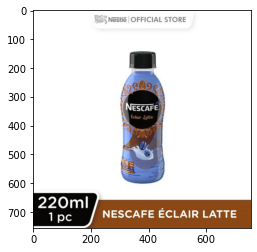

In [10]:
plt.imshow(img_temp)

In [14]:
# Labelencoder for labels
encoder = preprocessing.LabelEncoder()
train_csv['label_group']  = encoder.fit_transform(train_csv['label_group'])


**Targets column**

For each image we add a column containing the posting_id of all images belonging to the same label group


In [15]:
#Creating target column (The ground truth)
tmp = train_csv.groupby('label_group').posting_id.agg('unique')#.to_dict()
train_csv['target'] = train_csv.label_group.map(tmp)

In [13]:
train_csv.head()

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,6172,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,10509,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,9425,"[train_3369186413, train_921438619]"


In [14]:
# Number of labels
n_labels = max(train_csv["label_group"])+1
print(n_labels)

11014


In [15]:
train_csv.head(2)

,posting_id,image,image_phash,title,label_group,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,"[train_3386243561, train_3423213080]"


In [17]:
L=[]
for i in range(100):
    for j in range(100):
        if train_csv["image"][i]==train_csv["image"][j]:
            L.append((i,j))
    if i==1000:
        print("weee")
    

In [18]:
images = list(train_csv["image"])

In [313]:
L = []
for i in range(10000):
    for j in range(i+1,10000):
        if images[i]==images[j]:
            L.append((i,j))
    if i==1000:
        print("weee")

weee


In [319]:
M = []
labels = list(train_csv["label_group"])
for k in range(len(L)):
    i,j = L[k]
    if labels[i] != labels[j]:
        M.append((i,j))
        

In [330]:
train_csv[train_csv['label_group']==285]

,posting_id,image,image_phash,title,label_group,target,base_predictions,f1
1563,train_166945100,0c1da0c6bab51f1fe7df75ef060fc77d.jpg,eadad1350f6c7842,Waistbag Pushop Staye Pro Pulshop,285,"[train_166945100, train_1377183442, train_1583...","[train_2458596748, train_166945100]",0.4
5311,train_1377183442,283140c972494f6e83904e082ef61421.jpg,ab6ad0959fe03869,Waistbag Pushop Staye Pro,285,"[train_166945100, train_1377183442, train_1583...","[train_1377183442, train_1583259699]",0.8
10359,train_1583259699,4db10c2ae89a68e8192c5021dbf1311d.jpg,ab6ad0959fe03869,STAYE Professional Tas Pinggang,285,"[train_166945100, train_1377183442, train_1583...","[train_1377183442, train_1583259699]",0.8


Waistbag Pushop Staye Pro Pulshop
Waistbag Pushop Staye Pro
STAYE Professional Tas Pinggang


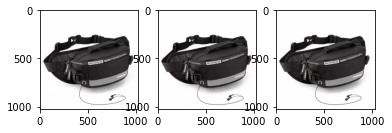

In [358]:
t_images = []
for i in [1563, 5311, 10359]:
    t_images.append(cv2.imread('train_images/'+ train_csv.iloc[1563]["image"]))
    print(train_csv.iloc[i]["title"])

fig, axis = plt.subplots(1, 3)
for i in range(3):
    axis[i].imshow(t_images[i])
#plt.imshow(img_temp)

In [360]:
t_images2 = []
c=0
m = len(train_csv[train_csv['label_group']==3222])
for i in train_csv[train_csv['label_group']==3222].index[:20]:
    t_images2.append(cv2.imread('train_images/'+ train_csv.iloc[i]["image"]))
    if c<5: 
        print(train_csv.iloc[i]["title"])
    c+=1


NEW WAISTBAG ALA KOREA - Tas Selempang Pria Wanita
Pushop Waistbag Pria Traveling Waterproof Professional Staye
Tas Selempang Pria Wanita
TAS SELEMPANG PRIA
Tas Selempang Pria Wanita


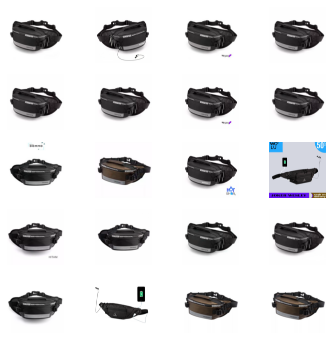

In [356]:
fig, axis = plt.subplots(5, 4, figsize=(6,6))
for i in range(20):
    axis[i//4,i%4].imshow(t_images2[i])
    axis[i//4,i%4].axis("off")

In [336]:
len(train_csv[train_csv['label_group']==3222])

37

In [331]:
train_csv.iloc[1563]

posting_id                                            train_166945100
image                            0c1da0c6bab51f1fe7df75ef060fc77d.jpg
image_phash                                          eadad1350f6c7842
title                               Waistbag Pushop Staye Pro Pulshop
label_group                                                       285
target              [train_166945100, train_1377183442, train_1583...
base_predictions                  [train_2458596748, train_166945100]
f1                                                                0.4
Name: 1563, dtype: object

In [324]:
train_csv[1562:1564]

,posting_id,image,image_phash,title,label_group,target,base_predictions,f1
1562,train_2458596748,0c1da0c6bab51f1fe7df75ef060fc77d.jpg,eadad1350f6c7842,Pushop Waistbag Pria Traveling Waterproof Prof...,3222,"[train_1065906242, train_2458596748, train_165...","[train_2458596748, train_166945100]",0.051282
1563,train_166945100,0c1da0c6bab51f1fe7df75ef060fc77d.jpg,eadad1350f6c7842,Waistbag Pushop Staye Pro Pulshop,285,"[train_166945100, train_1377183442, train_1583...","[train_2458596748, train_166945100]",0.400000


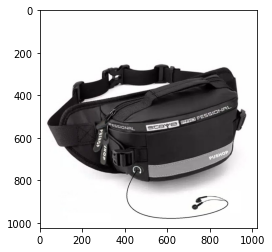

In [325]:
img_temp = cv2.imread('train_images/0c1da0c6bab51f1fe7df75ef060fc77d.jpg')
plt.imshow(img_temp)

In [321]:
M[:5]

[(1562, 1563), (1651, 1652), (1651, 1658), (1651, 1660), (1652, 1653)]

**Baseline model score**

The baseline model is a model that predicts two matching products if they have the same hash

In [19]:
# Calculating score of baseline model

tmp = train_csv.groupby('image_phash').posting_id.agg('unique').to_dict()
train_csv['base_predictions'] = train_csv.image_phash.map(tmp)

def getMetric(col):
    def f1score(row):
        n = len(np.intersect1d(row.target,row[col]))
        return 2*n / (len(row.target)+len(row[col]))
    return f1score
"""col = 'base_predictions'
def f1score(row, col=col):
        n = len(np.intersect1d(row.target,row[col]))
        return 2*n / (len(row.target)+len(row[col]))"""

train_csv['f1'] = train_csv.apply(getMetric('base_predictions'), axis=1)

In [20]:
# F1 score of our base model 
train_csv['f1'].mean()

0.5530933399168149

In [21]:
train_csv.head()

,posting_id,image,image_phash,title,label_group,target,base_predictions,f1
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,"[train_129225211, train_2278313361]",[train_129225211],0.666667
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,"[train_3386243561, train_3423213080]",[train_3386243561],0.666667
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,6172,"[train_2288590299, train_3803689425]",[train_2288590299],0.666667
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,10509,"[train_2406599165, train_3342059966]",[train_2406599165],0.666667
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,9425,"[train_3369186413, train_921438619]",[train_3369186413],0.666667


In [22]:
train_csv = train_csv.drop('f1', axis=1)

In [68]:
label_frequency = [0 for _ in range(11014)]
for i in range(len(train_csv)):
    label_frequency[train_csv.label_group[i]]+=1
    
    

Text(0, 0.5, 'Data entries ')

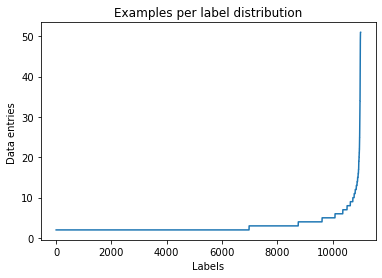

In [281]:
plt.plot(np.sort(label_frequency))
plt.title("Examples per label distribution")
plt.xlabel("Labels")
plt.ylabel("Data entries ")

In [65]:
train_csv.label_group[0]

666

In [23]:
# Data augmentation

"""transforms_train = albumentations.Compose([albumentations.HorizontalFlip(p=0.5),
                                           albumentations.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
                                           albumentations.HueSaturationValue(p=0.5, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
                                           albumentations.ShiftScaleRotate(p=0.5, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
                                           albumentations.CoarseDropout(p=0.5),
                                           albumentations.Normalize()])
"""
transforms_train = albumentations.Compose([albumentations.HorizontalFlip(p=0.5)])

In [23]:
# Arcface implementation (Not tested yet)

class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output

class AddMarginProduct(nn.Module):
    r"""Implement of large margin cosine distance: :
    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        s: norm of input feature
        m: margin
        cos(theta) - m
    """

    def __init__(self, in_features, out_features, s=30.0, m=0.40):
        super(AddMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        phi = cosine - self.m
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size())
        # one_hot = one_hot.cuda() if cosine.is_cuda else one_hot
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
        output *= self.s
        # print(output)

        return output

In [16]:
# Createing dataset
class ShopeeDataset(Dataset):
    def __init__(self, csv, transforms=None, imsize = 512):
        self.csv = csv
        self.transforms = transforms
        self.imsize = imsize
    def __len__(self):
        return self.csv.shape[0]

    def __getitem__(self, index):
        row = self.csv.iloc[index]
        title = row.title
        img = cv2.imread('train_images/'+row.image)
        if self.transforms != None:
          img = self.transforms(image = img)['image']
        img= transforms.ToTensor()(img)
        
        img = transforms.Resize((self.imsize,self.imsize))(img)
        #img = img.unsqueeze(dim = 0)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img,torch.tensor(row.label_group)

In [25]:
# Createing dataset
class ShopeeDataset_text(Dataset):
    def __init__(self, csv):
        self.csv = csv
    def __len__(self):
        return self.csv.shape[0]
    def __getitem__(self, index):
        row = self.csv.iloc[index]
        title = row.title
        return title,torch.tensor(row.label_group)

In [17]:
# Defining dataset
ds = ShopeeDataset(train_csv, imsize= 512)

In [25]:
class ShopeeImageDataset(Dataset):
    def __init__(self, img_path, transform):
        self.img_path = img_path
        self.transform = transform
        
    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        img = self.transform(img)
        return img
    
    def __len__(self):
        return len(self.img_path)

In [27]:
imagedataset = ShopeeImageDataset(
    train_csv['image'].values,
    transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

In [10]:
class ShopeeImageEmbeddingNet(nn.Module):
    def __init__(self):
        super(ShopeeImageEmbeddingNet, self).__init__()
              
        model = models.resnet18(True)
        model.avgpool = nn.AdaptiveMaxPool2d(output_size=(1, 1))
        model = nn.Sequential(*list(model.children())[:-1])
        model.eval()
        self.model = model
        
    def forward(self, img):        
        out = self.model(img)
        return out

In [11]:
imgmodel = ShopeeImageEmbeddingNet()

In [28]:
imageloader = torch.utils.data.DataLoader(
    imagedataset,
    batch_size=40, shuffle=False,
)


In [29]:
imagefeat = []
with torch.no_grad():
    for data in tqdm(imageloader):
        data = data
        feat = imgmodel(data)
        feat = feat.reshape(feat.shape[0], feat.shape[1])
        feat = feat.data.numpy()
        

  0%|          | 0/857 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '0000a68812bc7e98c42888dfb1c07da0.jpg'

In [27]:
len(ds)

34250

In [40]:
ds[0][0].size()

torch.Size([3, 512, 512])

In [41]:
# Defining train loader
train_loader = torch.utils.data.DataLoader(
        ds,
        batch_size=120,
        drop_last=True
    )

torch.Size([120, 3, 512, 512])


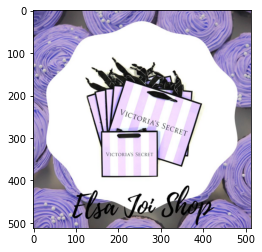

In [42]:
for x,y in train_loader:
  print(x.size())
  plt.imshow(transforms.ToPILImage()(x[0]))
  break

In [368]:
#Dataset using augmented data
ds_augmentee = ShopeeDataset(train_csv, imsize= 512, transforms=transforms_train)

In [369]:
ds_augmentee[0][0].size()

torch.Size([3, 512, 512])

In [370]:
train_loader_augmentee =torch.utils.data.DataLoader(
        ds_augmentee,
        batch_size=120,
        pin_memory=True,
        drop_last=True
    )


torch.Size([120, 3, 512, 512])


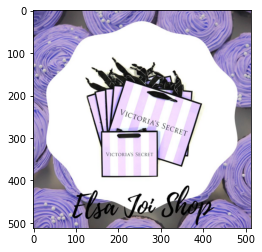

In [371]:
for x,y in train_loader_augmentee:
  print(x.size())
  plt.imshow(transforms.ToPILImage()(x[0]))
  break

In [34]:
# Random network just for test
class RandNet(nn.Module):
    def __init__(self, n_classes, fc_dim = 24):
        super(RandNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, kernel_size = 3, padding = 1)
        self.maxpool = nn.MaxPool2d(2, stride = 2)
        self.layers = nn.Sequential(self.conv1, nn.ReLU(), self.maxpool)
        self.final_layer = nn.Linear(4*12*12, n_classes)
        
    def embedding(self, x):
        vector = self.layers(x)
        #vector = self.maxpool(vector)
        return (vector)
    
    def forward(self,x):
        z = self.embedding(x)
        z= z.view(-1,4*12*12)
        return self.final_layer(z)
        

In [35]:
rdn = RandNet(n_labels)

In [36]:
for x,y in train_loader:
  print(x.size())
  print(y)
  print(rdn(x))
  break

torch.Size([120, 3, 24, 24])
tensor([  666,  7572,  6172, 10509,  9425,  6836,  4687,  3976,  6076,  6754,
         6347,  1306,  1306, 10797,  4940,   897,  4002,  6058,  8795,  5382,
         9363,  1363, 10874,  5732, 10391,  1039,  5192,  7555,  1366,  1366,
         2333,  6351, 10937,  9246, 10069,  4148,  6817,  8584,  9843,  2575,
         3012,   260,  2466,  2512,  2719,  5085,  3907,  9392,  3280,  4728,
         2994,  7285,   947,  3529,  5705,  7647,  3499,  3499,   561,   561,
         2119,  3128,   510,  9011,  3970,  9251,  4355,  2038,  5853,  9794,
          919,  9830,   383,  2922, 10577,  9011,  3203,  2569,  4839,  2072,
         6861,  8675, 10643,  2787,  9251,  2994,  3466,  4812,  8510,  6222,
         8036,  8720,  6951,  2102,  2930,  3096,  4472,  2994,  9011,  9011,
         7975,  3646, 10629,  4538,  2716,  2716,  2716,  2716,  8785,  8785,
          909,  9364,  5191,  4849,  3250,   316,  6806,  9518, 10730,   950])
tensor([[ 0.2585, -0.1644, -0.1369

In [28]:
# Defining the model 

class Shopee_net(nn.Module):
    
    def __init__(self, n_classes = 11014, pretrained=True, loss_module='ArcFace' ):
        super(Shopee_net, self).__init__()
        #self.backbone = timm.create_model(backbone, pretrained=pretrained)
        self.backbone = models.resnet18(pretrained=True)
        '''for param in model.parameters(): # Freezing model backpropagation 
            param.requires_grad = False'''
        self.n_classes = n_classes # Here it's the number of different labels encountered in training dataset
        #self.in_features = self.backbone.classifier[0].in_features
        #self.backbone.classifier = nn.Identity() # We restrict our model to the feauture extraction part
        self.in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.fc = nn.Linear(self.in_features, 11014)
        """
        self.fc = nn.Sequential(nn.Linear(self.in_features, 32), 
                                 nn.ReLU(), 
                                 nn.Dropout(0.5),
                                 nn.Linear(32, 11014)) # We add a linear layer """
        #self.loss = ArcMarginProduct(self.in_features, n_classes)
        
      
    def extract_features(self, x):
        return self.backbone(x)   
          
    def forward(self, x):
        features = self.backbone(x)
        x = self.fc(features)
        return x
        
        
    

In [29]:
net = Shopee_net()

In [30]:
# Defining the model 

class Shopee_net2(nn.Module):
    
    def __init__(self, n_classes = 11014, pretrained=True, loss_module='ArcFace' ):
        super(Shopee_net2, self).__init__()
        #self.backbone = timm.create_model(backbone, pretrained=pretrained)
        self.backbone = models.alexnet(pretrained=pretrained)
        '''for param in model.parameters(): # Freezing model backpropagation 
            param.requires_grad = False'''
        self.n_classes = n_classes # Here it's the number of different labels encountered in training dataset
        #self.in_features = self.backbone.classifier[0].in_features
        #self.backbone.classifier = nn.Identity() # We restrict our model to the feauture extraction part
        self.in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Linear(self.in_features, 256)
        self.fc = nn.Linear(256, 11014)
        """
        self.fc = nn.Sequential(nn.Linear(self.in_features, 32), 
                                 nn.ReLU(), 
                                 nn.Dropout(0.5),
                                 nn.Linear(32, 11014)) # We add a linear layer """
        #self.loss = ArcMarginProduct(self.in_features, n_classes)
        
      
    def extract_features(self, x):
        return self.backbone(x)   
          
    def forward(self, x):
        features = self.backbone(x)
        x = self.fc(features)
        return x
        

In [31]:
net2 = Shopee_net2()

In [32]:
models.alexnet(pretrained=True)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [132]:
#Training
def train_fn(dataloader, model, criterion, optimizer, epoch):
    model.train()
    #loss_score = AverageMeter()
    loss_score = 0
    #t = time.time()
    tot = len(dataloader)
    #for i,d in tqdm(enumerate(dataloader), total=tot):
    i = 0
    for images,targets in tqdm(dataloader, total=tot):
        print(images.size())
        batch_size = targets.shape[0]
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,targets)
        loss.backward()
        optimizer.step()
        #loss_score.update(loss.detach().item(), batch_size)
        loss_score+= loss
        #tk0.set_postfix(Train_Loss=loss_score.avg,Epoch=epoch,LR=optimizer.param_groups[0]['lr'])
        
        break
    return loss_score

In [140]:
# Defining train loader
train_loader = torch.utils.data.DataLoader(
        ds,
        batch_size=64,
        drop_last=True
    )

In [ ]:
i = 0
for images,targets in tqdm(train_loader):
    output = net(images)
    i+=1
    if i==3:
        break

  0%|          | 1/535 [00:24<3:38:59, 24.61s/it]

In [34]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
#train_fn(train_loader, net, criterion, optimizer, 2)

In [62]:
# Model creation using vgg16 for transfer learning
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
inf = model.classifier[0].in_features
model.classifier = nn.Sequential(nn.Linear(inf, 512), 
                                 nn.ReLU(), 
                                 nn.Dropout(0.5),
                                 nn.Linear(512, 11014))


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [59]:
bbb = model.classifier

In [61]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [51]:
mdl.fc.in_features

512

In [95]:
# Average
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
from time import time

In [36]:
optimizer = torch.optim.Adam(rdn.parameters(), lr = 1e-3)
loss = nn.CrossEntropyLoss()
                             

In [158]:
"""train_fn(train_loader, rdn, loss, optimizer, 1)"""

'train_fn(train_loader, rdn, loss, optimizer, 1)'

In [35]:
# Implement knn :

# Distance:

def eucDistance(x1, x2):
    n = x1.size(-1) 
    assert x2.size(-1) == n, "Warning ! Different embedding size"
    res = 0
    for i in range(n):
        #res += (x1[...,i]-x2[...,i])**2
        res += (x1[i] - x2[i])**2
    return np.sqrt(res)

def cosineDistance(x1, x2):
    n = x1.size(-1) 
    assert x2.size(-1) == n, "Warning ! Different embedding size"
    res = 0
    for i in range(n):
        #res += (x1[...,i]-x2[...,i])**2
        res += (x1[i]*x2[i])
    res /= torch.norm(x1.float())*torch.norm(x2.float())

# Alternatively we'll use pytorch implemented method :

cosine = nn.CosineSimilarity(dim=1, eps = 1e-6)

thresh = 0.7 

def naive_knn(train_emb, instance, k=51, threshold = thresh):
    # train_emb : a tensor containing training embeddings 
    # instance : An instance embedding
    # We use k=51 by default because we know there are at most 50 similar products (+ eventually the product itself)
    n = len(train_emb)
    similarities = torch.zeros(n)
    for i in range(n):
        similarities[i] = cosine(train_emb[i], instance)
    sorted_similarities, sorted_indices = similarities.sort(descending = True) # 
    ind =[]
    sim = []
    for i in range(k):
        if sorted_similarities[i] > threshold:
            sim.append(sorted_similarities[i])
            ind.append(sorted_indices[i])
    return ind, sim

# TODO implement some threshold tuning 

# We suppose now that we have access to embeddings directly in a column embcol ='embeddings'
# or embcol='text_embeddings' or embcol = 'image_embeddings' in train_csv
# For each data entry, the corresponding match is going to be in the form (indices, distances) 

def add_matches_column(embcol, k=51, threshold = thresh, dataframe = train_csv):
    embeddings = list(dataframe[embcol])
    n = len(dataframe)
    matches = [[] for i in range(n)]
    for i in range(n):
        ind, sim = naive_knn(embeddings, dataframe[embcol][i], k, threshold)
        matches[i] = [(ind[j], sim[j]) for j in range(len(ind))]
    column_name = embcol+"_matches"
    dataframe[column_name] = matches


In [83]:
# We use combined thresholding
def union_match(col1, col2, dataframe = train_csv):
    # col1 and col2 are matches column added by the function add_matches_column
    n = len(dataframe)
    union = [[] for i in range(n)]
    for i in range(n):
        match1 = set(dataframe[col1][i])
        match2 = set(dataframe[col2][i])
        union[i] = list(match1|match2)
    dataframe["union_"+col1+"_"+col2][i] = union
       
def union_match(col1, col2, col3, union_col_name : str, dataframe = train_csv):
    # col1 and col2 are matches column added by the function add_matches_column
    n = len(dataframe)
    union = [0 for i in range(n)]
    for i in range(n):
        match1 = set(dataframe[col1][i])
        match2 = set(dataframe[col2][i])
        match3 = set(dataframe[col3][i])
        union[i] = list(match1|match2|match3)
    dataframe[union_col_name] = union
        
        
# Blending embedding from matches 
# We are going to compare the direct blending approach to a weighted blending method 
# where the weights are the similarities

def blend_embedding(matchescol, embcol, dataframe = train_csv):
    n = len(dataframe)
    newembcol = [0 for i in range(n)]
    for i in range(n):
        emb = dataframe[embcol][i]
        counter = 1
        for element in dataframe[matchescol][i]:
            idx, sim = element
            emb += dataframe[embcol][idx]
            counter += 1
        emb /= counter
        newembcol[i] = emb
    dataframe['blend_'+embcol] =  newembcol
        
def weighted_blend_embedding(matchescol, embcol, dataframe = train_csv):
    n = len(dataframe)
    newembcol = [0 for i in range(n)]
    for i in range(n):
        emb = dataframe[embcol][i]
        counter = 1
        for element in dataframe[matchescol][i]:
            idx, sim = element
            counter += sim
            emb += sim*dataframe[embcol][int(idx)]
        emb /= counter
        newembcol[i] = emb
    dataframe['weighted_blend_'+embcol] =  newembcol
    

    


In [107]:
cols_name_dict = {0:"img", 1:"txt"}
def add_emb_col(model, dataframe = train_csv, dataset=ds, idx = 0):
    # model is a pytorch model that has the member function extract_features
    # idx is the index of embedding : repectively 0,1 or 2 for image or text or combined embedding
    n = len(dataframe)
    embed = [0 for i in range(n)]
    for i in tqdm(range(n), total=n):
        embed[i] = model.extract_features(dataset[i][0].unsqueeze(0))
    dataframe[cols_name_dict[idx]+"_emb"] = embed
    


In [56]:
# A proper comb embedding column is needed for 
def com_emb_col(emb1, emb2, dataframe = train_csv):
    #embeddings = list(torch.cat([torch.tensor(dataframe[emb1]), torch.tensor(dataframe[emb2])], dim= 1))
    l1 = list(dataframe[emb1])
    l2 = list(dataframe[emb2])
    n = len(dataframe)
    embeddings = [0 for i in range(n)]
    for i in range(n):
        embeddings[i] = torch.cat([l1[i], l2[i]], dim = 1)
    dataframe["comb_emb"] = embeddings

def add_comb_matches_column(emb1, emb2, dataframe = train_csv, k =51, threshold = thresh):
    #embeddings = torch.cat([torch.tensor(dataframe[emb1]), torch.tensor(dataframe[emb2])], dim= 1)
    l1 = list(dataframe[emb1])
    l2 = list(dataframe[emb2])
    n = len(dataframe)
    embeddings = [0 for i in range(n)]
    for i in range(n):
        embeddings[i] = torch.cat([l1[i], l2[i]], dim = 1)
    matches = [0 for i in range(n)]
    for i in range(n):
        ind, sim = naive_knn(embeddings, torch.tensor(dataframe[embcol][i]), k, threshold)
        matches[i] = [(ind[j], sim[j]) for j in range(len(ind))]
    column_name = "comb_matches"
    dataframe[column_name] = matches

# Final matches function

def final_matches(matches_col, dataframe = train_csv):
    n = len(dataframe)
    f_matches = [[] for i in range(n)]
    for i in range(n):
        for elm in dataframe[matches_col][i]:
            idx = elm[0]
            f_matches[i].append(dataframe.iloc[int(idx)]["posting_id"])
    dataframe["final_matches"] = f_matches

In [111]:
t_csv = train_csv[:1000]
t_ds = [ds[i] for i in range(1000)]

In [42]:
add_emb_col(net, t_csv, ds, idx = 0) # 40s for 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [43]:
add_emb_col(net2, t_csv, ds, idx = 1) #14s 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [60]:
com_emb_col('img_emb', 'txt_emb', t_csv) # Instant run time

0.021996021270751953


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [65]:
t = time.time()
add_matches_column("img_emb", k=51, threshold = 0.8, dataframe = t_csv)
print(time.time()-t)

0.6737382411956787


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [69]:
add_matches_column("txt_emb", k=51, threshold = 0.8, dataframe = t_csv)
add_matches_column("comb_emb", k=51, threshold = 0.8, dataframe = t_csv)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [76]:
union_match("img_emb_matches", "txt_emb_matches", "comb_emb_matches", "union1_matches", t_csv) # Intant run time

0.0184171199798584


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [84]:
weighted_blend_embedding("union1_matches", "comb_emb", t_csv)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [88]:
t = time.time()
add_matches_column("weighted_blend_comb_emb", 51, 0.8, t_csv)
print(time.time()-t)

0.664630651473999


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [91]:
final_matches("weighted_blend_comb_emb_matches", t_csv)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
l1 = list(t_csv['img_emb'])
l2 = list(t_csv['txt_emb'])


In [100]:
# Implementing the blending pipline

def blending_pipeline(dataframe = train_csv, dataset = ds, text=False, k = 51, thresholds = [0.8, 0.7, 0.7]):
    add_emb_col(net, dataframe, dataset, idx = 0)
    add_matches_column('img_emb',  k, thresholds[0], dataframe)
    if text==False:
        final_matches('img_emb_matches', dataframe)
    else :
        add_emb_col(net2, dataframe, dataset, idx = 1)
        add_matches_column('txt_emb', k, thresholds[1], dataframe )
        com_emb_col('img_emb', 'txt_emb', dataframe)
        #add_comb_matches_column('img_emb', 'txt_emb', dataframe, thresholds[2])
        add_matches_column('comb_emb', k, thresholds[1], dataframe )
        union_match("img_emb_matches", "txt_emb_matches", "comb_emb_matches", "union1_matches", dataframe)
        weighted_blend_embedding("union1_matches", "comb_emb", dataframe)
        add_matches_column("weighted_blend_comb_emb", k, thresholds[2], dataframe)
        final_matches("weighted_blend_comb_emb_matches", dataframe)
    
    

In [ ]:
t = time.time()
blending_pipeline(t_csv, t_ds, text=True)
print(time.time()-t)

 18%|█▊        | 181/1000 [01:14<05:15,  2.59it/s]

In [105]:
t_csv.head(2)

,posting_id,image,image_phash,title,label_group,target,base_predictions,img_emb,img_emb_matches,txt_emb,txt_emb_matches,comb_emb,comb_emb_matches,union1_matches,weighted_blend_comb_emb,weighted_blend_comb_emb_matches,final_matches,f1
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,"[train_129225211, train_2278313361]",[train_129225211],"[[tensor(0.9315, grad_fn=<UnbindBackward>), te...","[(tensor(0), tensor(1., grad_fn=<SelectBackwar...","[[tensor(0.5358, grad_fn=<UnbindBackward>), te...","[(tensor(0), tensor(1., grad_fn=<SelectBackwar...","[[tensor(2.4506, grad_fn=<UnbindBackward>), te...","[(tensor(0), tensor(1., grad_fn=<SelectBackwar...","[(tensor(71), tensor(0.9989, grad_fn=<SelectBa...","[[tensor(2.4506, grad_fn=<UnbindBackward>), te...","[(tensor(0), tensor(1., grad_fn=<SelectBackwar...","[train_129225211, train_998568945, train_18029...",0.037736
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,"[train_3386243561, train_3423213080]",[train_3386243561],"[[tensor(0.8917, grad_fn=<UnbindBackward>), te...","[(tensor(1), tensor(1., grad_fn=<SelectBackwar...","[[tensor(0.0774, grad_fn=<UnbindBackward>), te...","[(tensor(1), tensor(1., grad_fn=<SelectBackwar...","[[tensor(2.9544, grad_fn=<UnbindBackward>), te...","[(tensor(1), tensor(1., grad_fn=<SelectBackwar...","[(tensor(71), tensor(0.9987, grad_fn=<SelectBa...","[[tensor(2.9544, grad_fn=<UnbindBackward>), te...","[(tensor(1), tensor(1., grad_fn=<SelectBackwar...","[train_3386243561, train_3589506283, train_304...",0.037736


In [95]:
t_csv.head(2)

,posting_id,image,image_phash,title,label_group,target,base_predictions,img_emb,txt_emb,comb_emb,img_emb_matches,txt_emb_matches,comb_emb_matches,union1_matches,weighted_blend_comb_emb,weighted_blend_comb_emb_matches,final_matches,f1
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,"[train_129225211, train_2278313361]",[train_129225211],"[[tensor(0.9315, grad_fn=<UnbindBackward>), te...","[[tensor(0.5358, grad_fn=<UnbindBackward>), te...","[[tensor(3.4505, grad_fn=<UnbindBackward>), te...","[(tensor(0), tensor(1., grad_fn=<SelectBackwar...","[(tensor(0), tensor(1., grad_fn=<SelectBackwar...","[(tensor(0), tensor(1., grad_fn=<SelectBackwar...","[(tensor(34), tensor(0.9989, grad_fn=<SelectBa...","[[tensor(3.4505, grad_fn=<UnbindBackward>), te...","[(tensor(0), tensor(1., grad_fn=<SelectBackwar...","[train_129225211, train_1802986387, train_2771...",0.037736
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,"[train_3386243561, train_3423213080]",[train_3386243561],"[[tensor(0.8917, grad_fn=<UnbindBackward>), te...","[[tensor(0.0774, grad_fn=<UnbindBackward>), te...","[[tensor(2.0713, grad_fn=<UnbindBackward>), te...","[(tensor(1), tensor(1., grad_fn=<SelectBackwar...","[(tensor(1), tensor(1., grad_fn=<SelectBackwar...","[(tensor(1), tensor(1., grad_fn=<SelectBackwar...","[(tensor(11), tensor(0.9990, grad_fn=<SelectBa...","[[tensor(2.0713, grad_fn=<UnbindBackward>), te...","[(tensor(1), tensor(1., grad_fn=<SelectBackwar...","[train_3386243561, train_1327117441, train_277...",0.037736


In [576]:
nn.CosineSimilarity(dim=1, eps=1e-08)(t_csv["image_emb"][3], t_csv["image_emb"][0])

tensor([0.9989], grad_fn=<DivBackward0>)

In [104]:
# Calculates the f1 score 

t_csv['f1'] = t_csv.apply(getMetric('final_matches'), axis=1)
t_csv['f1'].mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.04219198085624034

In [662]:
add_emb_col(net2, t_csv, t_ds, idx = 1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [438]:
a = torch.tensor([[1,2], [3,2]])
b = torch.tensor([[3,5,6], [10,2,3]])
torch.cat([a,b], dim=1)

tensor([[ 1,  2,  3,  5,  6],
        [ 3,  2, 10,  2,  3]])

In [425]:
add_img_emb_col(net, t_csv, t_ds)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [427]:
t_csv.head(2)

,posting_id,image,image_phash,title,label_group,target,base_predictions,image_emb
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,"[train_129225211, train_2278313361]",[train_129225211],"[[tensor(0.9315, grad_fn=<UnbindBackward>), te..."
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,"[train_3386243561, train_3423213080]",[train_3386243561],"[[tensor(0.8917, grad_fn=<UnbindBackward>), te..."


In [ ]:
blending_pipeline(t_csv, t_ds, text=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [411]:
net.extract_features(ds[0][0].unsqueeze(0)).size()

torch.Size([1, 512])

In [382]:
with torch.set_grad_enabled(False):
    for x,y in train_loader:
        featt = net.extract_features(x)
        print(featt.size())
        break
        

torch.Size([64, 512])


In [273]:
A  = set([1,2,3])
B= set({3,4,5})
list(A|B)

[1, 2, 3, 4, 5]

In [263]:
li = [1,2,3]
b = torch.Tensor(li)

In [268]:
b==c

tensor([True, True, True])

In [245]:
a

tensor([0, 4, 2])

In [261]:
b = torch.tensor([0,1,0])

In [262]:
cosine(a.float(),b.float())

tensor(0.8944)

In [234]:
a.sort()[1]

tensor([0, 2, 1])

**TO DO :**
- F1 score and evaluation of baseline ✅ 
- Data augmentation  
- Arcface metric implementation ✅
- Transfer training using some model like effnet ✅
- Add two embedding columns : Text embedding and image embedding
- Implementing knn to determine the predictions ✅
- Implementing some threshold tuning 
- Blending matches that are calculated from text and image embeddings  
- CV score and evaluation of model predictions
- Modify code to use cuda



**Notes** 

The goal of the loss function is to minimize the maximum intra-class distance while keeping the features of different classes separable. Chosing the right loss function that can enhance the discrimnative power is key to our problem.

How to reduce the effect of the background

After embeddings, we use knn with k=51 using cosine similarity (cosine distance is equivalent to normalizing feauture vectors prior to calculating their euclidean distance)


What makes this competition hard ?
- The scarcity of data associated to each label makes it an unsupervised learning task
- Data is multi-modal
